In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def prepare_data(df, target_column='Close', sequence_length=60):
    features = df.drop(columns=[target_column]).values  
    target = df[target_column].values  

    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    
    features_scaled = scaler_features.fit_transform(features)
    target_scaled = scaler_target.fit_transform(target.reshape(-1, 1))

    X, y = [], []
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i - sequence_length:i])  
        y.append(target_scaled[i, 0])  

    X, y = np.array(X), np.array(y)
    
    return X, y, scaler_features, scaler_target

In [12]:
def load_stock_data(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

In [ ]:
def train_gru_model(stock, filepath):
    print(f"Processing {stock} stock...")

    df = load_stock_data(filepath)
    X, y, scaler_features, scaler_target = prepare_data(df)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential([
        Bidirectional(GRU(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Bidirectional(GRU(units=50, return_sequences=False)),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    predictions = model.predict(X_test)
    predictions = scaler_target.inverse_transform(predictions)  
    y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    mse = tf.keras.losses.MeanSquaredError()(y_test_actual, predictions).numpy()
    r2 = 1 - (np.sum((y_test_actual - predictions) ** 2) / np.sum((y_test_actual - np.mean(y_test_actual)) ** 2))

    print(f"Stock: {stock} | MSE: {mse:.5f}, R2: {r2:.5f}")

    plt.figure(figsize=(10, 5))
    plt.plot(df.index[-len(y_test_actual):], y_test_actual, label='Actual Close Price', color='blue')
    plt.plot(df.index[-len(y_test_actual):], predictions, label='Predicted Close Price', color='red')
    plt.title(f"{stock} Stock Price Prediction using GRU")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

Processing NVIDIA stock...
Epoch 1/50
158/158 [==============================] - 16s 47ms/step - loss: 1.8301e-04 - val_loss: 0.0026 - lr: 0.0010
Epoch 2/50
158/158 [==============================] - 5s 35ms/step - loss: 2.1268e-05 - val_loss: 0.0014 - lr: 0.0010
Epoch 3/50
158/158 [==============================] - 5s 33ms/step - loss: 1.1560e-05 - val_loss: 0.0025 - lr: 0.0010
Epoch 4/50
158/158 [==============================] - 5s 32ms/step - loss: 8.3673e-06 - val_loss: 0.0036 - lr: 0.0010
Epoch 5/50
158/158 [==============================] - 5s 33ms/step - loss: 5.8108e-06 - val_loss: 0.0030 - lr: 0.0010
Epoch 6/50
158/158 [==============================] - 5s 32ms/step - loss: 4.7741e-06 - val_loss: 0.0027 - lr: 0.0010
Epoch 7/50
158/158 [==============================] - 5s 32ms/step - loss: 4.0374e-06 - val_loss: 0.0039 - lr: 0.0010
Epoch 8/50
158/158 [==============================] - 5s 32ms/step - loss: 3.2638e-06 - val_loss: 0.0028 - lr: 5.0000e-04
Epoch 9/50
158/158 [====

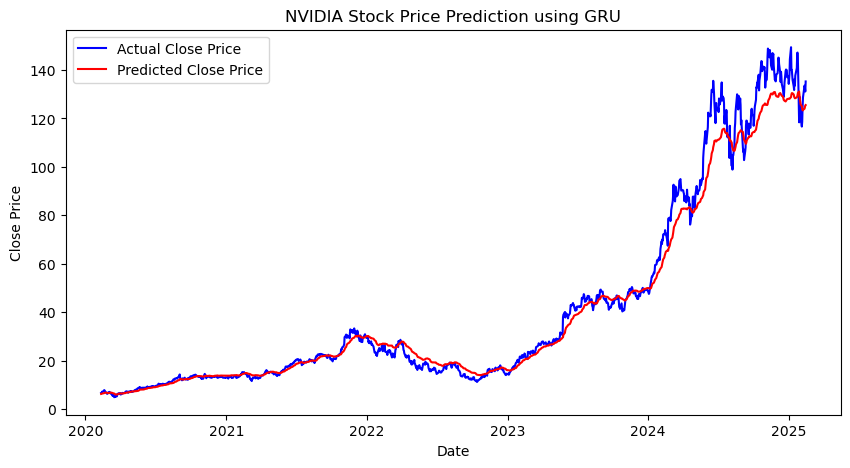

In [5]:
# Run for each stock
train_gru_model('NVIDIA', '../data/nvidia_stock_features_selected.csv')

Processing Microsoft stock...
Epoch 1/50
239/239 [==============================] - 14s 39ms/step - loss: 8.3338e-04 - val_loss: 0.0069 - lr: 0.0010
Epoch 2/50
239/239 [==============================] - 8s 34ms/step - loss: 9.1757e-05 - val_loss: 0.0029 - lr: 0.0010
Epoch 3/50
239/239 [==============================] - 8s 33ms/step - loss: 4.8746e-05 - val_loss: 0.0017 - lr: 0.0010
Epoch 4/50
239/239 [==============================] - 8s 33ms/step - loss: 3.1661e-05 - val_loss: 0.0024 - lr: 0.0010
Epoch 5/50
239/239 [==============================] - 8s 33ms/step - loss: 2.4260e-05 - val_loss: 0.0018 - lr: 0.0010
Epoch 6/50
239/239 [==============================] - 8s 33ms/step - loss: 1.8628e-05 - val_loss: 0.0032 - lr: 0.0010
Epoch 7/50
239/239 [==============================] - 8s 33ms/step - loss: 1.5773e-05 - val_loss: 0.0012 - lr: 0.0010
Epoch 8/50
239/239 [==============================] - 8s 34ms/step - loss: 1.2337e-05 - val_loss: 9.6694e-04 - lr: 0.0010
Epoch 9/50
239/239 [=

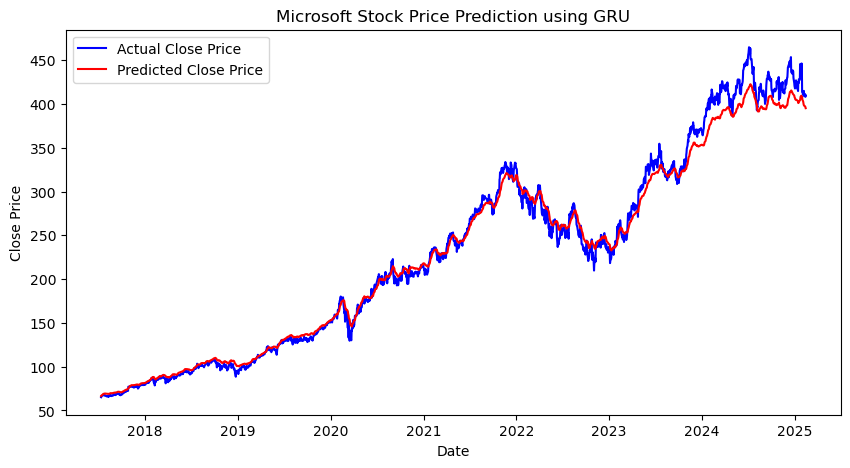

In [6]:
train_gru_model('Microsoft', '../data/microsoft_stock_features_selected.csv')

Processing Apple stock...
Epoch 1/50
272/272 [==============================] - 16s 38ms/step - loss: 4.5335e-04 - val_loss: 0.0036 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - 9s 35ms/step - loss: 4.7352e-05 - val_loss: 0.0032 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - 9s 34ms/step - loss: 2.7308e-05 - val_loss: 0.0035 - lr: 0.0010
Epoch 4/50
272/272 [==============================] - 10s 35ms/step - loss: 1.8048e-05 - val_loss: 0.0019 - lr: 0.0010
Epoch 5/50
272/272 [==============================] - 9s 34ms/step - loss: 1.5040e-05 - val_loss: 0.0048 - lr: 0.0010
Epoch 6/50
272/272 [==============================] - 9s 34ms/step - loss: 1.2940e-05 - val_loss: 0.0046 - lr: 0.0010
Epoch 7/50
272/272 [==============================] - 9s 34ms/step - loss: 1.0334e-05 - val_loss: 0.0013 - lr: 0.0010
Epoch 8/50
272/272 [==============================] - 10s 37ms/step - loss: 1.0378e-05 - val_loss: 0.0040 - lr: 0.0010
Epoch 9/50
272/272 [=======

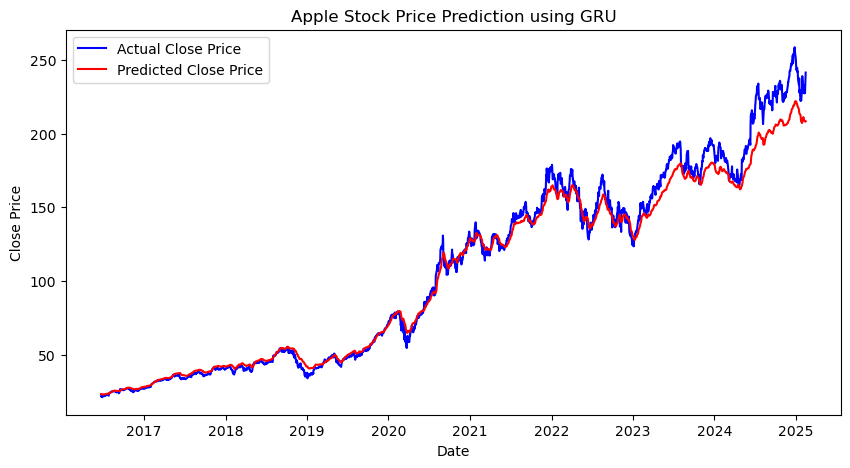

In [7]:
train_gru_model('Apple', '../data/apple_stock_features_selected.csv')

The GRU models did comparitively much better than LSTMs with mse as default loss function let's try and implement our custom loss function as well to see if we are able to further improve our prediciton.

In [13]:
def custom_weighted_loss(y_true, y_pred):
    weights = tf.range(1, tf.shape(y_true)[0] + 1, dtype=tf.float32)
    weights = tf.math.exp(weights/tf.reduce_max(weights))
    mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    loss = mse(y_true, y_pred)
    return tf.reduce_mean(loss*weights)

In [ ]:
def custom_gru_model(stock, filepath):
    df = load_stock_data(filepath)
    X, y, scaler_features, scaler_target = prepare_data(df)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential([
        Bidirectional(GRU(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Bidirectional(GRU(units=50, return_sequences=False)),
        Dropout(0.1),
        Dense(units=25),
        Dense(units=1)
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3), loss=custom_weighted_loss)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    predictions = model.predict(X_test)
    predictions = scaler_target.inverse_transform(predictions)
    y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    mse = tf.keras.losses.MeanSquaredError()(y_test_actual, predictions).numpy()
    r2 = 1 - (np.sum((y_test_actual - predictions)**2) / np.sum((y_test_actual - np.mean(y_test_actual))**2))

    print(f"Stock: {stock} | MSE: {mse:.5f}, R2: {r2:.5f}")

    plt.figure(figsize=(10, 5))
    plt.plot(df.index[-len(y_test_actual):], y_test_actual, label='Actual Close Price', color='blue')
    plt.plot(df.index[-len(y_test_actual):], predictions, label='Predicted Close Price', color='red')
    plt.title(f"{stock} Stock Price Prediction using LSTM")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

Epoch 1/50
158/158 [==============================] - 14s 50ms/step - loss: 3.4053e-04 - val_loss: 0.0140 - lr: 0.0010
Epoch 2/50
158/158 [==============================] - 6s 40ms/step - loss: 2.8069e-05 - val_loss: 0.0044 - lr: 0.0010
Epoch 3/50
158/158 [==============================] - 6s 39ms/step - loss: 1.6456e-05 - val_loss: 0.0056 - lr: 0.0010
Epoch 4/50
158/158 [==============================] - 6s 39ms/step - loss: 1.2299e-05 - val_loss: 0.0050 - lr: 0.0010
Epoch 5/50
158/158 [==============================] - 7s 42ms/step - loss: 9.5049e-06 - val_loss: 0.0054 - lr: 0.0010
Epoch 6/50
158/158 [==============================] - 6s 39ms/step - loss: 7.4738e-06 - val_loss: 0.0051 - lr: 0.0010
Epoch 7/50
158/158 [==============================] - 6s 41ms/step - loss: 6.0773e-06 - val_loss: 0.0035 - lr: 0.0010
Epoch 8/50
158/158 [==============================] - 6s 41ms/step - loss: 5.4521e-06 - val_loss: 0.0041 - lr: 0.0010
Epoch 9/50
158/158 [==============================] - 6

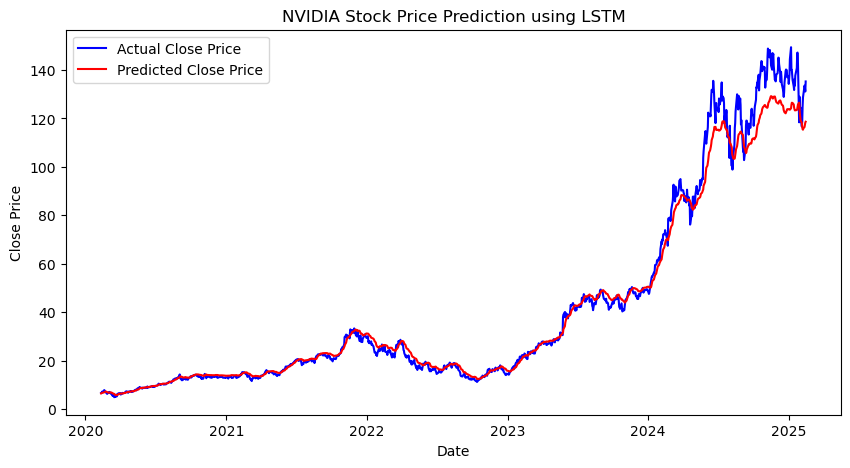

In [15]:
custom_gru_model('NVIDIA', '../data/nvidia_stock_features_selected.csv')

Epoch 1/50
272/272 [==============================] - 18s 46ms/step - loss: 0.0010 - val_loss: 0.0022 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - 12s 44ms/step - loss: 9.8659e-05 - val_loss: 0.0039 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - 12s 44ms/step - loss: 4.8421e-05 - val_loss: 0.0069 - lr: 0.0010
Epoch 4/50
272/272 [==============================] - 10s 38ms/step - loss: 3.3593e-05 - val_loss: 0.0043 - lr: 0.0010
Epoch 5/50
272/272 [==============================] - 9s 35ms/step - loss: 2.5745e-05 - val_loss: 0.0040 - lr: 0.0010
Epoch 6/50
272/272 [==============================] - 9s 35ms/step - loss: 1.9050e-05 - val_loss: 0.0056 - lr: 0.0010
Epoch 7/50
272/272 [==============================] - 9s 35ms/step - loss: 1.5902e-05 - val_loss: 0.0041 - lr: 5.0000e-04
Epoch 8/50
272/272 [==============================] - 9s 34ms/step - loss: 1.4743e-05 - val_loss: 0.0058 - lr: 5.0000e-04
Epoch 9/50
272/272 [============================

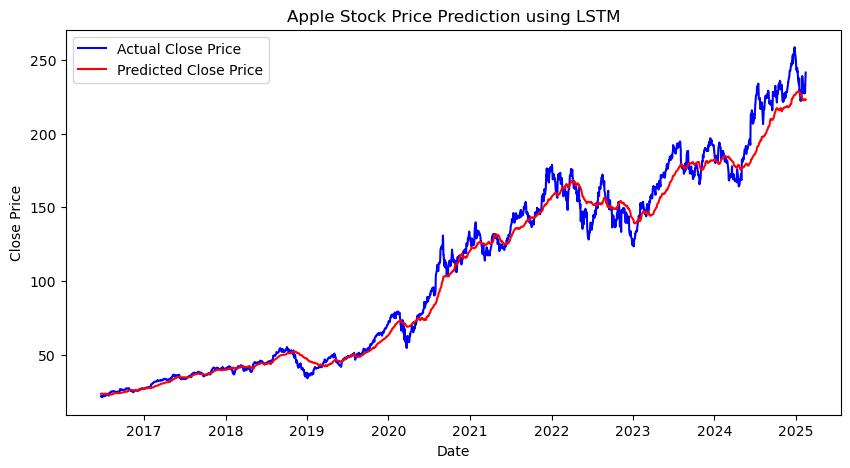

In [16]:
custom_gru_model('Apple', '../data/apple_stock_features_selected.csv')

Epoch 1/50
239/239 [==============================] - 14s 40ms/step - loss: 0.0011 - val_loss: 0.0063 - lr: 0.0010
Epoch 2/50
239/239 [==============================] - 8s 34ms/step - loss: 9.6935e-05 - val_loss: 0.0026 - lr: 0.0010
Epoch 3/50
239/239 [==============================] - 8s 34ms/step - loss: 5.7374e-05 - val_loss: 0.0022 - lr: 0.0010
Epoch 4/50
239/239 [==============================] - 8s 34ms/step - loss: 4.1353e-05 - val_loss: 0.0037 - lr: 0.0010
Epoch 5/50
239/239 [==============================] - 8s 35ms/step - loss: 3.1559e-05 - val_loss: 0.0023 - lr: 0.0010
Epoch 6/50
239/239 [==============================] - 8s 34ms/step - loss: 2.5917e-05 - val_loss: 0.0028 - lr: 0.0010
Epoch 7/50
239/239 [==============================] - 8s 35ms/step - loss: 2.2359e-05 - val_loss: 0.0014 - lr: 0.0010
Epoch 8/50
239/239 [==============================] - 8s 35ms/step - loss: 1.8567e-05 - val_loss: 0.0015 - lr: 0.0010
Epoch 9/50
239/239 [==============================] - 8s 34

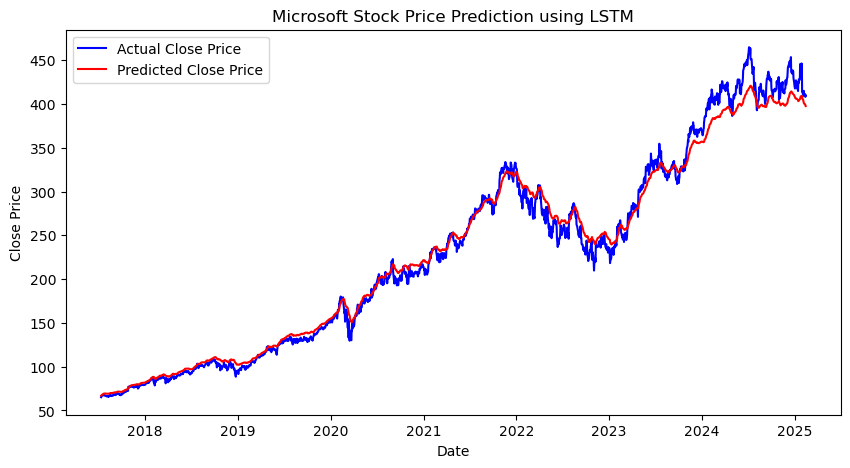

In [17]:
custom_gru_model('Microsoft', '../data/microsoft_stock_features_selected.csv')

Just as before we have comparable results, so far from our study LSTMs and GRUs have been able to give us the best possible results. We will now move on with transformer based models.